## Deep Learning training with CNN and an extended FastText word embedding
We test here the combination of:
* an embedding layer which is initialized with a pretrained fasttext word embedding extended with custom embedding model
* a CNN layer to capture word sequence representation
* a dense layer to learn classification

We leverage the pre-trained fasttext word embedding model gracefully supplied by Facebook company at [https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)

This general purpose word embedding model is extended with custom model generated by [fasttext_embedding_extension_builder.ipynb](fasttext_embedding_extension_builder.ipynb) script

In [20]:
# Keras
import keras
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
import sys
sys.path.append('..')
from utils import vizu
from utils import serializer

embeddings_index = {}

In [21]:
from sklearn.model_selection import train_test_split

XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_clean_input_train.csv', sep=',')
YTrain = pd.read_csv('../../data/POSOS/label.csv', sep=';')

XTrain, XTest, YTrain, YTest = train_test_split(XTrain, YTrain, test_size=0.15, random_state=42)
num_classes = 51

In [22]:
from keras.preprocessing.sequence import pad_sequences

vocabulary_size = 10000
sequence_length = 15
embedding_out_dims = 300

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(XTrain['question'])

sequences = tokenizer.texts_to_sequences(XTrain['question'])
XEncodedTrain = pad_sequences(sequences, maxlen=sequence_length)

In [23]:
# load the French fasttext model
import os, re, csv, math, codecs
from tqdm import tqdm

if len(embeddings_index) == 0:
    
    f = codecs.open('../../pretrained_models/fasttext/wiki.fr.vec', encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

1152466it [02:27, 7801.31it/s]


In [24]:
# complete the embedding mode with the custom one built by the script additional_fasttext_embedding_builder.ipynb
customEmbedding = serializer.loadEmbeddingVector('../../pretrained_models/fasttext_embedding_extension.txt')

for k,v in customEmbedding.items():
    embeddings_index[k] = v 

In [25]:
nb_words = min(vocabulary_size, len(tokenizer.word_index))

embedding_matrix = np.zeros((nb_words+1, embedding_out_dims))

for word, i in tokenizer.word_index.items():
    if i >= nb_words:
        continue
                
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        raise Exception("unknown word=" + word)

###  <b>Build neural network with CNN and FastText embedding<b>

In [93]:
# hyper-parameters
drop_ratio = 0.40
num_filters = 100
hidden_dims = 100

kernel_sizes = [3,3,3]
pool_sizes= [3,3,15]

batch_size = 40
num_epochs= 200

strides = 1
patience = 30

In [94]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Convolution1D, MaxPooling1D, Dropout, Flatten, Input, Concatenate
from keras.layers.embeddings import Embedding


# tensor flow technical setting
#config = tf.ConfigProto(device_count={"CPU": 32})
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8, allow_growth = True)
config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True)
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

# build the neural network
model = Sequential()

# word embedding loaded from fasttext+extension
model.add(Embedding(
    input_dim=len(tokenizer.word_index)+1,
    output_dim=embedding_out_dims,
    weights=[embedding_matrix],
    input_length=sequence_length,
    trainable=False))

model.add(Dropout(drop_ratio))

# sequential convolution/pooling with different kernel sizes
for kernel_size, pool_size in zip(kernel_sizes, pool_sizes):

    model.add(Convolution1D(
        filters=num_filters,
        kernel_size=kernel_size,
        strides=strides,
        data_format='channels_first',
        activation='relu'))
    
    model.add(MaxPooling1D(pool_size=pool_size))          
          
model.add(Flatten())

model.add(Dropout(drop_ratio))

# classification layer
model.add(Dense(hidden_dims, activation="relu"))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 15, 300)           2429400   
_________________________________________________________________
dropout_37 (Dropout)         (None, 15, 300)           0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 100, 298)          4600      
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 33, 298)           0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 100, 296)          10000     
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 33, 296)           0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 100, 294)          10000     
__________

### Train the network

In [28]:
YOneHotEncodedTrain = keras.utils.to_categorical(YTrain['intention'])

In [95]:
# generate the tensorflow board
call_back_board = keras.callbacks.TensorBoard(
    log_dir='c:/git/CES/logs',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    write_grads=True,
    write_images=True,
    embeddings_freq=0,
    embeddings_layer_names=None,
    embeddings_metadata=None,
    embeddings_data=None)

# stop criterion to avoid overfitting
call_back_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=patience,
    verbose=0,
    mode='auto',
    baseline=None)

call_back_reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=patience/2
)

# learn !
model.fit(
    XEncodedTrain,
    np.array(YOneHotEncodedTrain),
    validation_split=0.15,
    epochs = num_epochs,
    batch_size=batch_size,
    verbose=2,
    #callbacks = [call_back_early_stopping, call_back_board, call_back_reduce_learning_rate])
    callbacks = [call_back_early_stopping, call_back_board])


Train on 5799 samples, validate on 1024 samples
Epoch 1/200
 - 2s - loss: 3.2697 - acc: 0.2195 - val_loss: 3.2354 - val_acc: 0.2129
Epoch 2/200
 - 2s - loss: 3.1509 - acc: 0.2250 - val_loss: 3.1468 - val_acc: 0.2168
Epoch 3/200
 - 2s - loss: 2.8964 - acc: 0.2738 - val_loss: 2.6666 - val_acc: 0.3086
Epoch 4/200
 - 2s - loss: 2.5381 - acc: 0.3457 - val_loss: 2.3033 - val_acc: 0.3994
Epoch 5/200
 - 2s - loss: 2.3193 - acc: 0.3990 - val_loss: 2.1404 - val_acc: 0.4453
Epoch 6/200
 - 2s - loss: 2.1954 - acc: 0.4247 - val_loss: 1.9875 - val_acc: 0.4854
Epoch 7/200
 - 2s - loss: 2.0619 - acc: 0.4530 - val_loss: 1.8950 - val_acc: 0.5088
Epoch 8/200
 - 2s - loss: 1.9899 - acc: 0.4637 - val_loss: 1.8545 - val_acc: 0.5000
Epoch 9/200
 - 2s - loss: 1.8963 - acc: 0.4856 - val_loss: 1.8000 - val_acc: 0.5176
Epoch 10/200
 - 2s - loss: 1.8725 - acc: 0.4972 - val_loss: 1.7742 - val_acc: 0.5088
Epoch 11/200
 - 2s - loss: 1.8026 - acc: 0.5066 - val_loss: 1.7071 - val_acc: 0.5537
Epoch 12/200
 - 2s - loss:

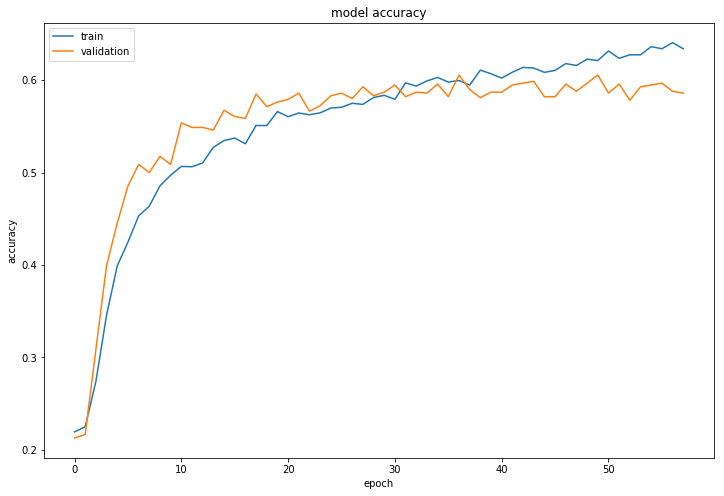

In [96]:
%matplotlib inline

vizu.plot_keras_model_learning_curve(model.history)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.47      0.51      0.49        35
          1       0.00      0.00      0.00         4
          2       1.00      0.40      0.57         5
          3       0.00      0.00      0.00         1
          4       1.00      0.64      0.78        11
          5       0.33      0.11      0.17        18
          6       0.43      0.75      0.55         4
          7       0.00      0.00      0.00         1
          8       0.88      0.56      0.68        25
          9       0.75      0.43      0.55         7
         10       0.38      0.25      0.30        12
         11       0.50      0.33      0.40        27
         12       0.50      0.33      0.40         6
         13       0.24      0.33      0.28        12
         14       0.32      0.40      0.36        42
         15       1.00      1.00      1.00         4
         16       0.67      0.67      0.67         3
         17       1.00      0.50      0.67   

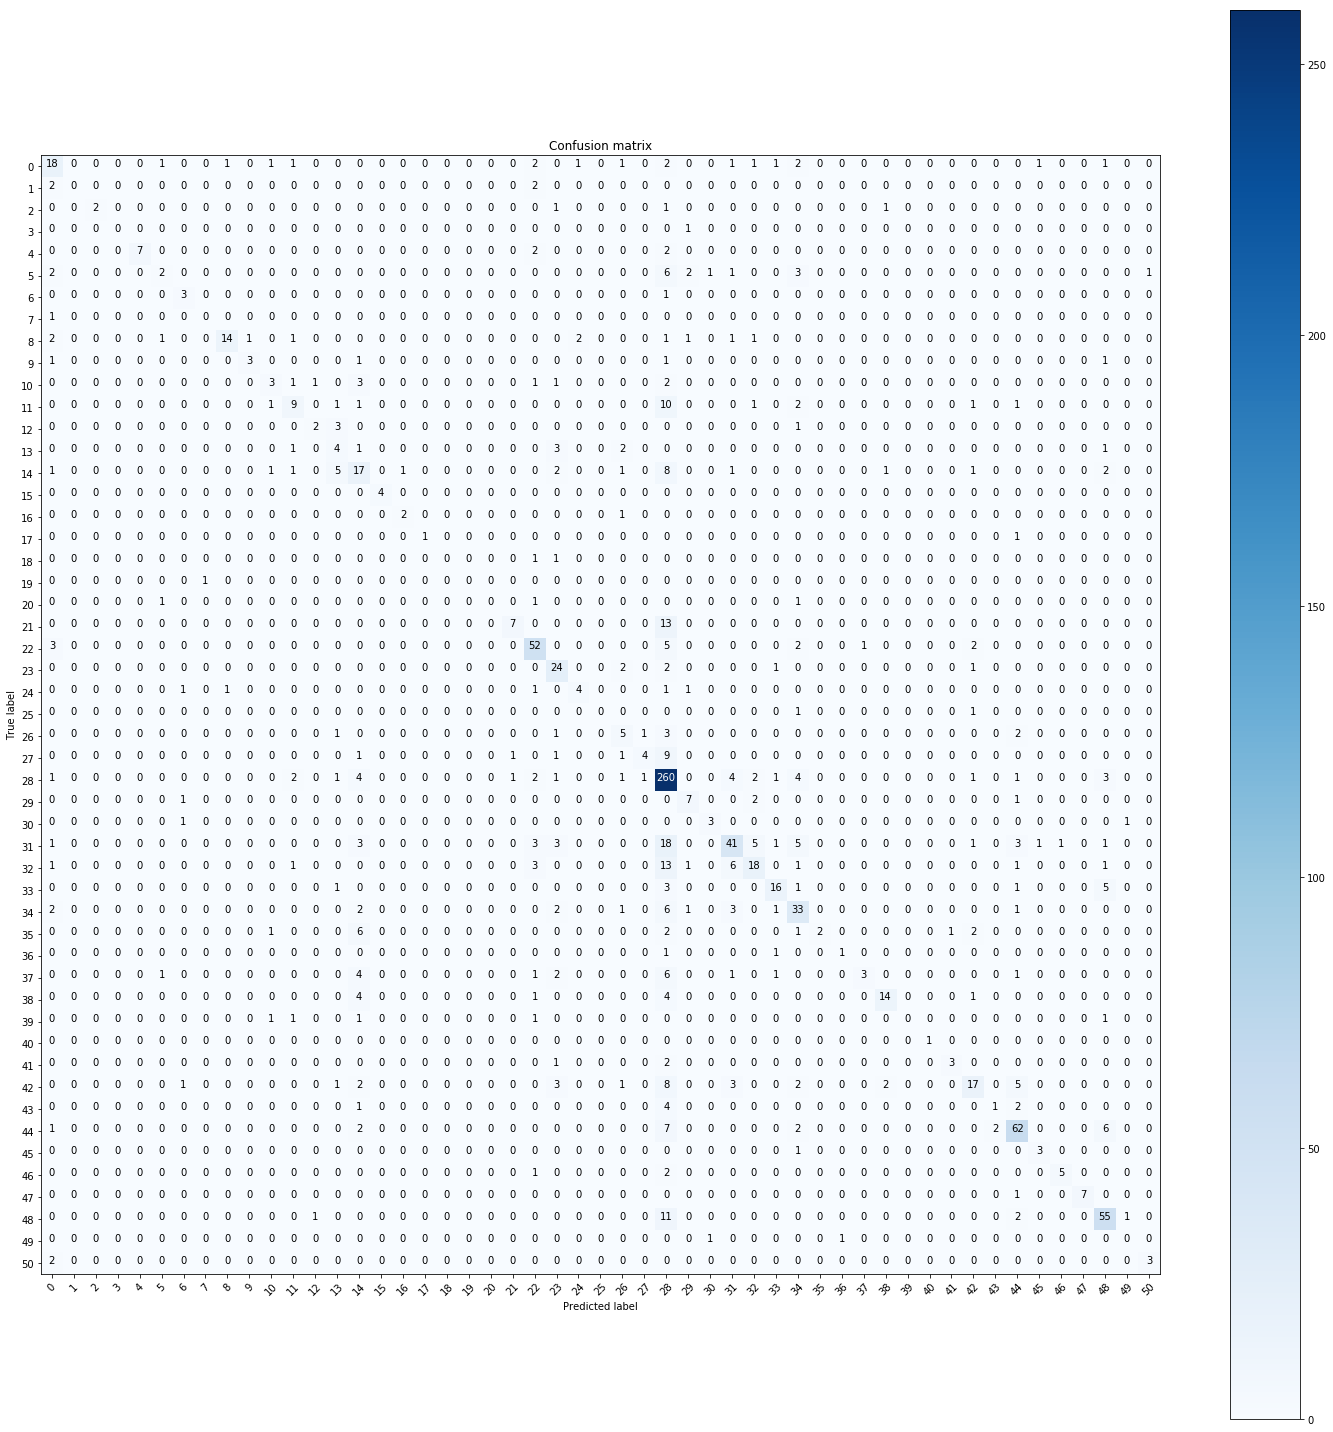

In [97]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

testSequences = tokenizer.texts_to_sequences(XTest['question'])
XEncodedTest = pad_sequences(testSequences, maxlen=sequence_length)
    
YTrue = YTest['intention']

YProba = model.predict(XEncodedTest)
YPredicted = YProba.argmax(axis=-1)


cnf_matrix = confusion_matrix(YTrue, YPredicted)

print(sklearn.metrics.classification_report(YTrue, YPredicted))

plt.figure(figsize=(20,20))

vizu.plot_confusion_matrix(cnf_matrix, normalize=False, classes = np.unique(YTrain['intention']))

plt.show()

In [98]:
macroF1Score = sklearn.metrics.f1_score(YTrue, YPredicted, average='macro')
microF1Score = sklearn.metrics.f1_score(YTrue, YPredicted, average='micro')
print ("micro F1 score = {:1.4f} ; macro F1 score = {:1.4f}".format(microF1Score, macroF1Score))

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


micro F1 score = 0.6158 ; macro F1 score = 0.4572
